# Adult Census Income Dataset from https://archive.ics.uci.edu/dataset/2/adult

## Imports + Getting Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as sklearn_logreg
from diffprivlib.models import LogisticRegression as dp_logreg
from sklearn.naive_bayes import GaussianNB as sklearn_gnb
from diffprivlib.models import GaussianNB as dp_gnb
from sklearn.tree import DecisionTreeClassifier as sklearn_dt
from diffprivlib.models import DecisionTreeClassifier as dp_dt
from sklearn.ensemble import RandomForestClassifier as sklearn_rf
from diffprivlib.models import RandomForestClassifier as dp_rf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../../Data/adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Pre-Processing

In [4]:
df[df == '?'] = np.nan
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna("other", inplace=True)

False

In [5]:
df = pd.get_dummies(df, columns=["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex", "native.country"])

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_other
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561,32561,32561,32561,...,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,<=50K,False,False,False,...,False,False,False,False,False,False,True,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,24720,31601,30468,32554,...,32447,32549,32481,32510,32543,32542,29170,32494,32545,31978
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X = df.drop("income", axis=1)
y = df[["income"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Helper Functions for Comparison

In [9]:
# Return Simulated Subsidy:
#   - If predicted annual income is <=50k and with a spouse, subsidy is 2000
#   - If predicted annual income is <=50k and without a spouse, subsidy is 1000
#   - Else, subsidy is 0
def getSubsidy(X, y):
    if y == "<=50K":
        if X['marital.status_Married-AF-spouse'] or X['marital.status_Married-civ-spouse']:
            return 2000
        return 1000
    return 0

# Return "Real" Subsidy Spend
def getRealSpend(X, y):
    real_spend = 0
    for i in range(len(y)):
        real_spend += getSubsidy(X.iloc[i], y[i])
    return real_spend

# Return Difference Between Predicted Subsidy and Real Subsidy Spends
def getTotalSpendDiff(X_test, y_pred, real_spend):
    pred_spend = 0
    for i in range(len(y_pred)):
        pred_spend += getSubsidy(X_test.iloc[i], y_pred[i])
    return pred_spend - real_spend

# Get K Features with Highest Absolute Coefficients from Baseline Logistic Regression
def getKBestFeatures(X_train_scaled, X_test_scaled, baseline_coefs, k):
    abs_baseline_coefs = np.absolute(baseline_coefs[0])
    ind = np.argpartition(abs_baseline_coefs, -k)[-k:]
    return X_train_scaled.iloc[:,ind], X_test_scaled.iloc[:,ind]

## Logistic Regression

### Baseline Model

In [10]:
#Create Baseline Logistic Regression Model
lr = sklearn_logreg().fit(X_train_scaled, y_train)  
lr_pred = cross_val_predict(lr, X_test_scaled, y_test, cv=10)

# Get Accuracy
lr_acc = accuracy_score(y_test, lr_pred)

# Get Subsidy Mismatch
real_spend = getRealSpend(X_test, y_test)
lr_spend_diff = getTotalSpendDiff(X_test, lr_pred, real_spend)
    
print("Baseline Accuracy:", lr_acc)
print("Baseline Subsidy Spend Difference:", lr_spend_diff)

Baseline Accuracy: 0.8471989577517216
Baseline Subsidy Spend Difference: 668000


### Trying for Different Numbers of Features

In [39]:
ks = range(1, len(X_train.columns) + 1)
epsilons = [1, 5, 10]

base_lr_accuracies = []
base_lr_spend_diffs = []

priv_lr_accuracies = [[] for _ in epsilons]
priv_lr_spend_diffs = [[] for _ in epsilons]
lr_coef_distances = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    # Create "baseline" Logistic Regression model using DP version with infinite epsilon
    base_lr = dp_logreg(epsilon=float('inf'), data_norm=100, max_iter=500).fit(X_train_topk, y_train)

    # base_lr_scores = cross_val_score(base_lr, X_test_topk, y_test, cv=10)
    base_lr_preds = cross_val_predict(base_lr, X_test_topk, y_test, cv=10)

    # Get Accuracy
    base_lr_accuracies.append(accuracy_score(y_test, base_lr_preds))

    # Get Subsidy Mismatch
    base_lr_spend_diffs.append(getTotalSpendDiff(X_test, base_lr_preds, real_spend))

    for e in range(len(epsilons)):
        priv_lr = dp_logreg(epsilon=epsilons[e], data_norm=100, max_iter=500, random_state=42).fit(X_train_topk, y_train)
        priv_lr_preds = cross_val_predict(priv_lr, X_test_topk, y_test, cv=10)

        # Get Accuracy
        priv_lr_accuracies[e].append(accuracy_score(y_test, priv_lr_preds))

        # Get Coefficient Distances
        lr_coef_distances[e].append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

        # Get Subsidy Mismatch
        priv_lr_spend_diffs[e].append(getTotalSpendDiff(X_test, priv_lr_preds, real_spend))

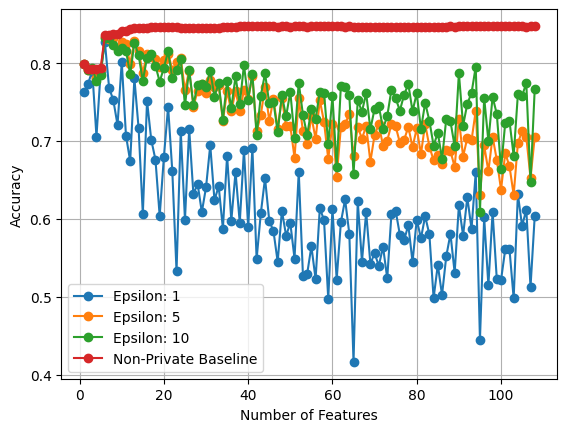

In [46]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_accuracies[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_accuracies * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

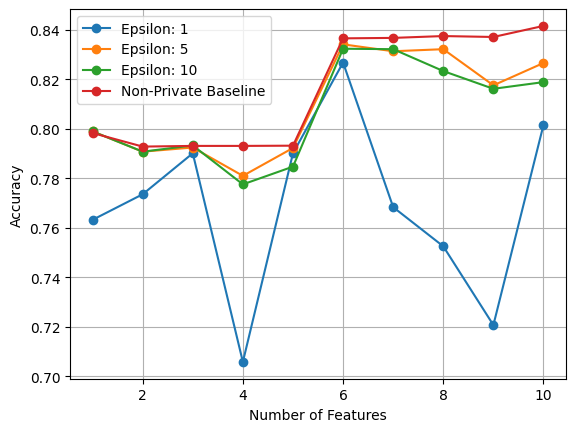

In [47]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_lr_accuracies[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_lr_accuracies[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

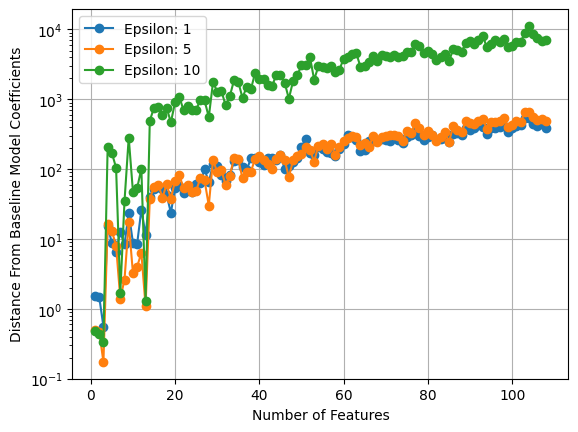

In [48]:
for e in range(len(epsilons)):
    plt.plot(ks, lr_coef_distances[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

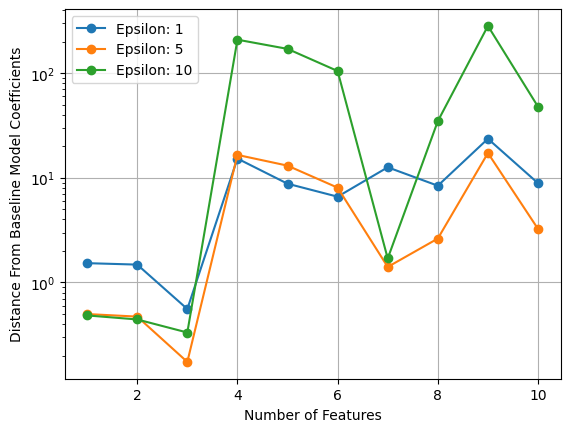

In [49]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], lr_coef_distances[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

Hypothetical Situation (Subsidy)
- If below 50k and with a spouse, get $1k per month
- If below 50k and without a spouse, get $2k per month
- Else, get $0 per month
- Calculate predicted spend – real spend per month.

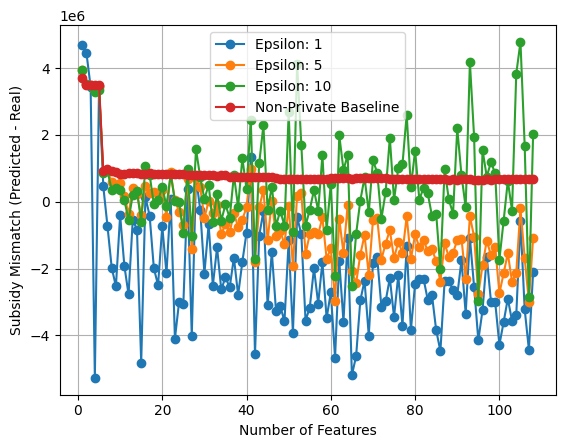

In [50]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_spend_diffs[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_spend_diffs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

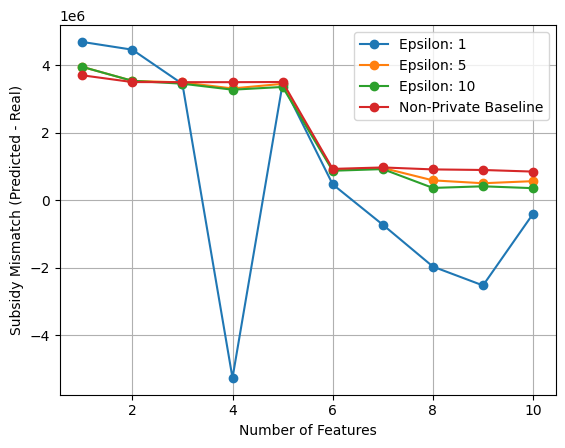

In [51]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_lr_spend_diffs[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_lr_spend_diffs[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline Logistic Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

### Logistic Regression Comparison Using Top 6 Features

In [89]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

# Create "baseline" Logistic Regression model using DP version with infinite epsilon
base_lr = dp_logreg(epsilon=float('inf'), data_norm=100, max_iter=500, random_state=42).fit(X_train_top6, y_train)
base_lr_preds = cross_val_predict(base_lr, X_test_top6, y_test, cv=10)

# Get Accuracy
base_lr_accuracy = accuracy_score(y_test, base_lr_preds)

# Get Subsidy Mismatch
base_lr_spend_diff = getTotalSpendDiff(X_test, base_lr_preds, real_spend)

In [53]:
epsilons = np.logspace(-2, 0.5, 50)
priv_lr_accuracies = []
priv_lr_spend_diffs = []
lr_coef_distances = []

for e in range(len(epsilons)):
    priv_lr = dp_logreg(epsilon=epsilons[e], data_norm=100, max_iter=500, random_state=42).fit(X_train_top6, y_train)
    priv_lr_preds = cross_val_predict(priv_lr, X_test_top6, y_test, cv=10)

    # Get Accuracy
    priv_lr_accuracies.append(accuracy_score(y_test, priv_lr_preds))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

    # Get Subsidy Mismatch
    priv_lr_spend_diffs.append(getTotalSpendDiff(X_test, priv_lr_preds, real_spend))
    
print("Accuracies:", priv_lr_accuracies)
print("Coefficient Distances:", lr_coef_distances)
print("Subsidy Spend Differences:", priv_lr_spend_diffs)

Accuracies: [0.34524474222966683, 0.34524474222966683, 0.34524474222966683, 0.34524474222966683, 0.34524474222966683, 0.3522240833798623, 0.3564116880699795, 0.35669086171598735, 0.35687697747999253, 0.35687697747999253, 0.3565047459519821, 0.3569700353619952, 0.35687697747999253, 0.3628326819281593, 0.36525218686022703, 0.36525218686022703, 0.41187418574353246, 0.41308393820956635, 0.41997022147775914, 0.4205285687697748, 0.4221105527638191, 0.43299832495812396, 0.43448725107016567, 0.4370928717662386, 0.43783733482225945, 0.44798064396054343, 0.44779452819653826, 0.5326633165829145, 0.5334077796389354, 0.6433091382840127, 0.6672250139586823, 0.6836032011911409, 0.7013772566536386, 0.7079843662758235, 0.7143123022520007, 0.7145914758980085, 0.7488367764749674, 0.810068862832682, 0.8264470500651405, 0.826819281593151, 0.827284571003164, 0.829890191699237, 0.8296110180532291, 0.8299832495812395, 0.8299832495812395, 0.83035548110925, 0.8314721756932812, 0.8320305229852969, 0.832495812395

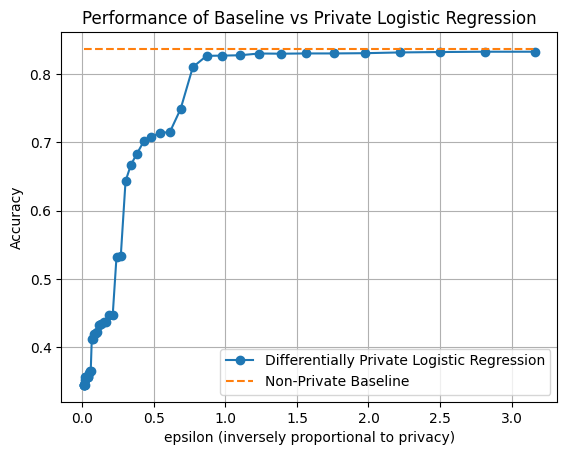

In [65]:
plt.plot(epsilons, priv_lr_accuracies, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of Baseline vs Private Logistic Regression")
plt.grid(axis="both")
plt.legend();

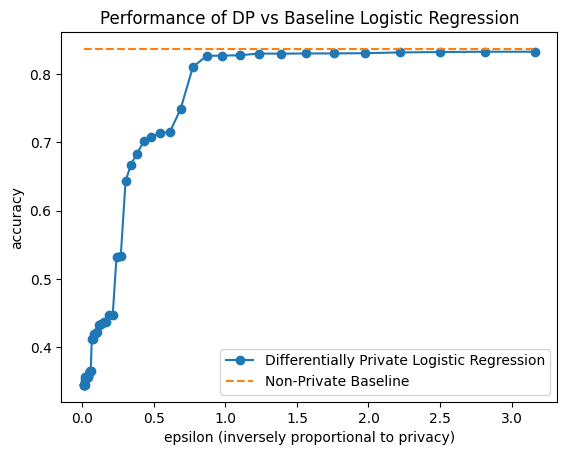

In [64]:
plt.plot(epsilons[:175], priv_lr_accuracies[:175], '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons[:175], base_lr_accuracy * np.ones_like(epsilons[:175]), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of DP vs Baseline Logistic Regression")
plt.legend();

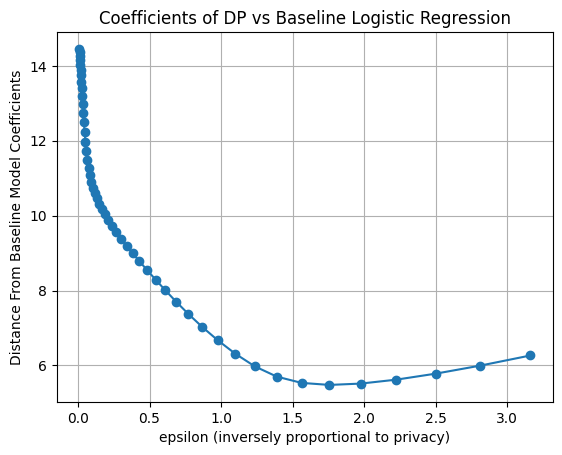

In [66]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Logistic Regression");

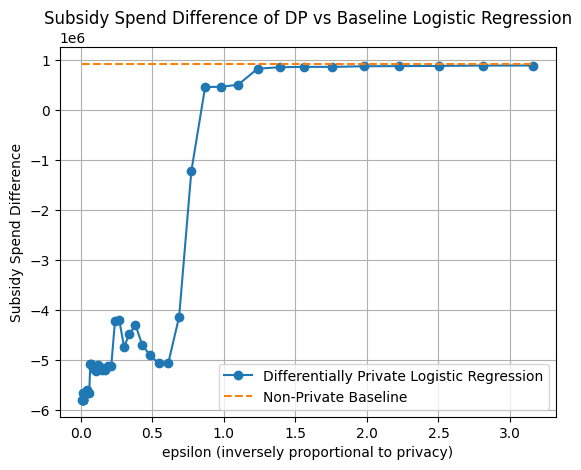

In [62]:
plt.plot(epsilons, priv_lr_spend_diffs, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.grid(axis="both")
plt.title("Subsidy Spend Difference of DP vs Baseline Logistic Regression")
plt.legend();

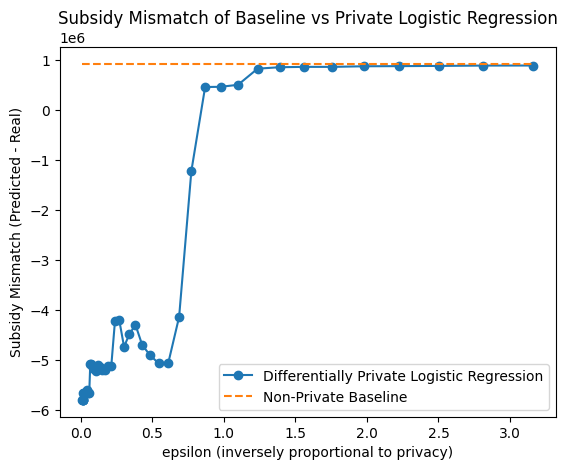

In [67]:
plt.plot(epsilons[:175], priv_lr_spend_diffs[:175], '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons[:175], base_lr_spend_diff * np.ones_like(epsilons[:175]), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.grid(axis="both")
plt.title("Subsidy Mismatch of Baseline vs Private Logistic Regression")
plt.legend();

### Logistic Regression, Top 6 Features, Averaging Performance

In [90]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

# Create "baseline" Logistic Regression model using DP version with infinite epsilon
base_lr = dp_logreg(epsilon=float('inf'), data_norm=100, max_iter=500, random_state=42).fit(X_train_top6, y_train)
base_lr_preds = cross_val_predict(base_lr, X_test_top6, y_test, cv=10)

# Get Accuracy
base_lr_accuracy = accuracy_score(y_test, base_lr_preds)

# Get Subsidy Mismatch
base_lr_spend_diff = getTotalSpendDiff(X_test, base_lr_preds, real_spend)

In [91]:
epsilons = np.logspace(-2, 0.75, 50)
priv_lr_accuracies = []
priv_lr_spend_diffs = []
lr_coef_distances = []

for e in range(len(epsilons)):
    current_accuracies = []
    current_coef_distances = []
    current_spend_diffs = []

    for i in range(10):
        priv_lr = dp_logreg(epsilon=epsilons[e], data_norm=100, max_iter=500).fit(X_train_top6, y_train)
        priv_lr_preds = cross_val_predict(priv_lr, X_test_top6, y_test, cv=10)

        # Get Accuracy
        current_accuracies.append(accuracy_score(y_test, priv_lr_preds))

        # Get Coefficient Distances
        current_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

        # Get Subsidy Mismatch
        current_spend_diffs.append(getTotalSpendDiff(X_test, priv_lr_preds, real_spend))
    
    priv_lr_accuracies.append(np.mean(current_accuracies))
    priv_lr_spend_diffs.append(np.mean(current_spend_diffs))
    lr_coef_distances.append(np.mean(current_coef_distances))
    
print("Accuracies:", priv_lr_accuracies)
print("Coefficient Distances:", lr_coef_distances)
print("Subsidy Spend Differences:", priv_lr_spend_diffs)

Accuracies: [0.5263260748185371, 0.48665549972082633, 0.5111948632049135, 0.5122650288479436, 0.5313046715056766, 0.5095477386934674, 0.5129350455983621, 0.5329331844407221, 0.5407035175879397, 0.4854736646193933, 0.501823934487251, 0.530467150567653, 0.5315280104224829, 0.5404057323655312, 0.5079843662758237, 0.5140331286059928, 0.5046342825237298, 0.5569048948445934, 0.5603666480550903, 0.5632049134561696, 0.5863391029220175, 0.5597338544574726, 0.6044388609715243, 0.6072026800670016, 0.5983156523357527, 0.6004094546808114, 0.6343569700353621, 0.6558440349897635, 0.6632235250325703, 0.65928717662386, 0.6846268378931695, 0.7041689931137167, 0.7037037037037036, 0.736571747627024, 0.7302810348036478, 0.7520286618276568, 0.7606644332774987, 0.772110552763819, 0.7920156337241764, 0.7937930392704262, 0.8015075376884422, 0.80143309138284, 0.8128885166573611, 0.8157733109994417, 0.8178391959798995, 0.8202773124883678, 0.8240554624976737, 0.8249115950120975, 0.8277126372603758, 0.828959612879

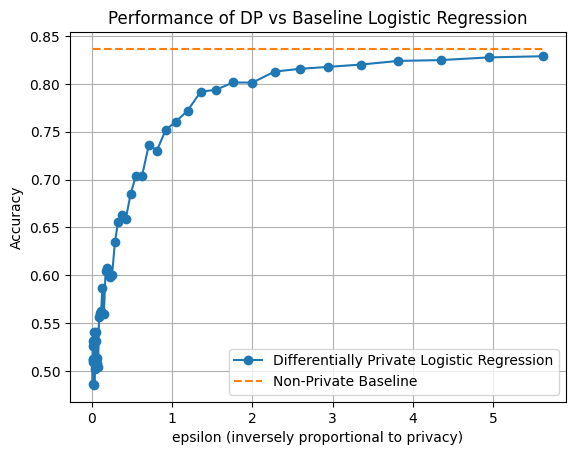

In [92]:
plt.plot(epsilons, priv_lr_accuracies, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Logistic Regression")
plt.grid(axis="both")
plt.legend();

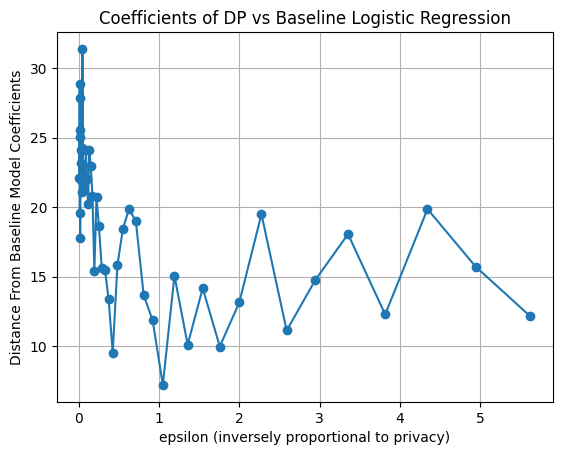

In [93]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Logistic Regression");

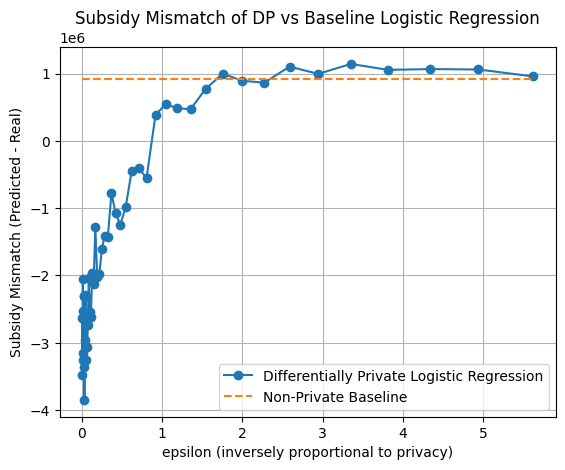

In [94]:
plt.plot(epsilons, priv_lr_spend_diffs, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.grid(axis="both")
plt.title("Subsidy Mismatch of DP vs Baseline Logistic Regression")
plt.legend();

### Logistic Regression Comparison Using All Features

In [78]:
# Create "baseline" Logistic Regression model using DP version with infinite epsilon
base_lr = dp_logreg(epsilon=float('inf'), data_norm=100, max_iter=500, random_state=42).fit(X_train_scaled, y_train)
base_lr_preds = cross_val_predict(base_lr, X_test_scaled, y_test, cv=10)

# Get Accuracy
base_lr_accuracy = accuracy_score(y_test, base_lr_preds)

# Get Subsidy Mismatch
base_lr_spend_diff = getTotalSpendDiff(X_test, base_lr_preds, real_spend)

In [79]:
epsilons = np.logspace(-2, 2, 200)
priv_lr_accuracies = []
priv_lr_spend_diffs = []
lr_coef_distances = []

for e in range(len(epsilons)):
    priv_lr = dp_logreg(epsilon=epsilons[e], data_norm=100, max_iter=500, random_state=42).fit(X_train_scaled, y_train)
    priv_lr_preds = cross_val_predict(priv_lr, X_test_scaled, y_test, cv=10)

    # Get Accuracy
    priv_lr_accuracies.append(accuracy_score(y_test, priv_lr_preds))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
    # Get Subsidy Mismatch
    priv_lr_spend_diffs.append(getTotalSpendDiff(X_test, priv_lr_preds, real_spend))
    
print("Accuracies:", priv_lr_accuracies)
print("Coefficient Distances:", lr_coef_distances)
print("Subsidy Spend Differences:", priv_lr_spend_diffs)

Accuracies: [0.5581611762516285, 0.5581611762516285, 0.5581611762516285, 0.5581611762516285, 0.5582542341336311, 0.5582542341336311, 0.5583472920156337, 0.5584403498976364, 0.5584403498976364, 0.5584403498976364, 0.5586264656616415, 0.5586264656616415, 0.5585334077796389, 0.5586264656616415, 0.5586264656616415, 0.5585334077796389, 0.5586264656616415, 0.5586264656616415, 0.5587195235436442, 0.5586264656616415, 0.5586264656616415, 0.5586264656616415, 0.5586264656616415, 0.5588125814256467, 0.5587195235436442, 0.5589056393076494, 0.558998697189652, 0.558998697189652, 0.558998697189652, 0.5590917550716545, 0.5590917550716545, 0.5591848129536572, 0.5592778708356598, 0.559463986599665, 0.559463986599665, 0.5595570444816675, 0.5598362181276754, 0.5600223338916807, 0.5601153917736832, 0.5600223338916807, 0.560394565419691, 0.560394565419691, 0.5607667969477015, 0.5609529127117067, 0.5608598548297041, 0.5608598548297041, 0.5609529127117067, 0.5611390284757118, 0.5616973757677275, 0.562162665177

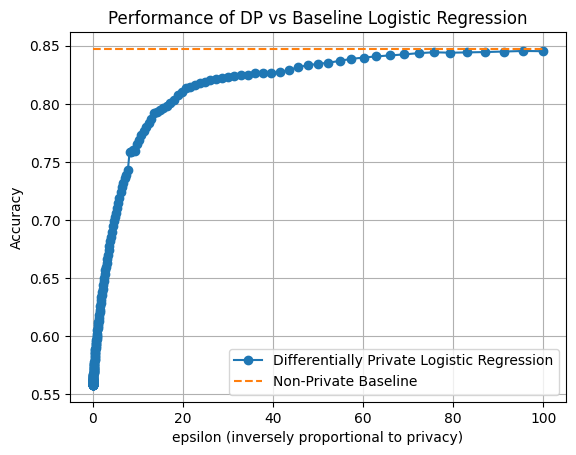

In [84]:
plt.plot(epsilons, priv_lr_accuracies, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Logistic Regression")
plt.grid(axis="both")
plt.legend();

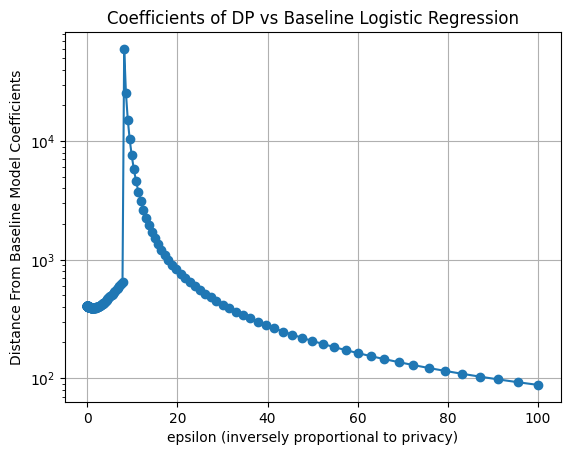

In [85]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Logistic Regression");

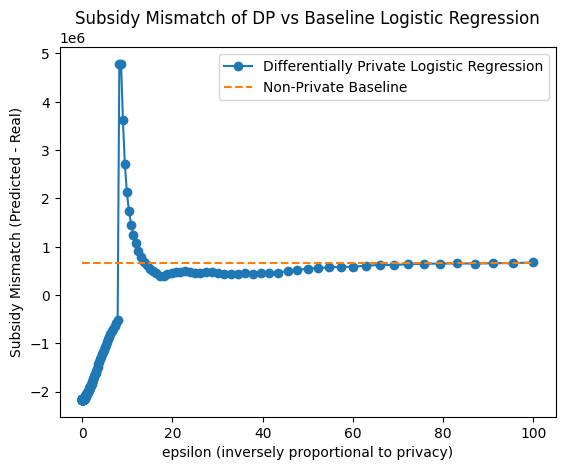

In [86]:
plt.plot(epsilons, priv_lr_spend_diffs, '-o', label="Differentially Private Logistic Regression")
plt.plot(epsilons, base_lr_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline Logistic Regression")
plt.legend();

## Gaussian Naive Bayes

### Baseline Model

In [90]:
#Create Baseline Gaussian Naive Bayes Model
gnb = sklearn_gnb().fit(X_train_scaled, y_train)  
gnb_pred = cross_val_predict(lr, X_test_scaled, y_test, cv=10)

# Get Accuracy
gnb_acc = accuracy_score(y_test, gnb_pred)

# Get Subsidy Mismatch
real_spend = getRealSpend(X_test, y_test)
gnb_spend_diff = getTotalSpendDiff(X_test, gnb_pred, real_spend)
    
print("Baseline Accuracy:", gnb_acc)
print("Baseline Subsidy Spend Difference:", gnb_spend_diff)

Baseline Accuracy: 0.8471989577517216
Baseline Subsidy Spend Difference: 668000


### Trying for Different Numbers of Features

In [ ]:
ks = range(1, len(X_train.columns) + 1)
epsilons = [1, 5, 10]

base_gnb_accuracies = []
base_gnb_spend_diffs = []

priv_gnb_accuracies = [[] for _ in epsilons]
priv_gnb_spend_diffs = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    # Create "baseline" Gaussian Naive Bayes model using DP version with infinite epsilon
    base_gnb = dp_gnb(epsilon=float('inf'), bounds=bounds_X, random_state=42).fit(X_train_topk, y_train)
    base_gnb_preds = cross_val_predict(base_gnb, X_test_topk, y_test, cv=10)

    # Get Accuracy
    base_gnb_accuracies.append(accuracy_score(y_test, base_gnb_preds))

    # Get Subsidy Mismatch
    base_gnb_spend_diffs.append(getTotalSpendDiff(X_test, base_gnb_preds, real_spend))

    for e in range(len(epsilons)):
        priv_gnb = dp_gnb(epsilon=epsilons[e], bounds=bounds_X, random_state=42).fit(X_train_topk, y_train)
        priv_gnb_preds = cross_val_predict(priv_gnb, X_test_topk, y_test, cv=10)

        # Get Accuracy
        priv_gnb_accuracies[e].append(accuracy_score(y_test, priv_gnb_preds))

        # Get Subsidy Mismatch
        priv_gnb_spend_diffs[e].append(getTotalSpendDiff(X_test, priv_gnb_preds, real_spend))

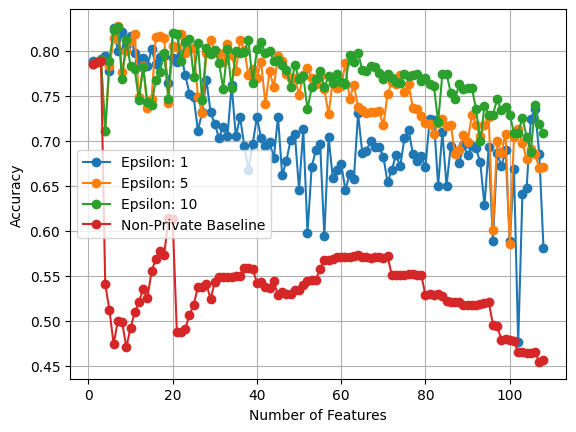

In [101]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_gnb_accuracies[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_gnb_accuracies * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Performance of Baseline vs Private Gaussian Naive Bayes for Different Number of Features")
plt.grid(axis="both")
plt.legend();

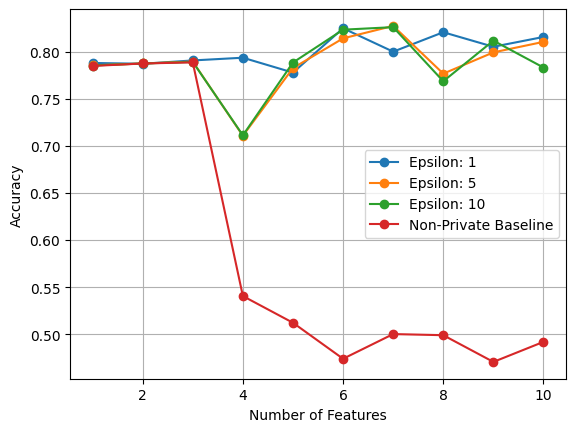

In [102]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_gnb_accuracies[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_gnb_accuracies[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Performance of Baseline vs Private Gaussian Naive Bayes for Different Number of Features")
plt.grid(axis="both")
plt.legend();

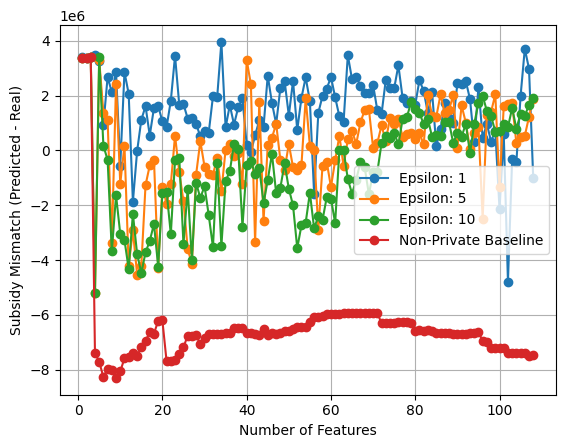

In [103]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_gnb_spend_diffs[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_gnb_spend_diffs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of Baseline vs Private Gaussian Naive Bayes for Different Number of Features")
plt.grid(axis="both")
plt.legend();

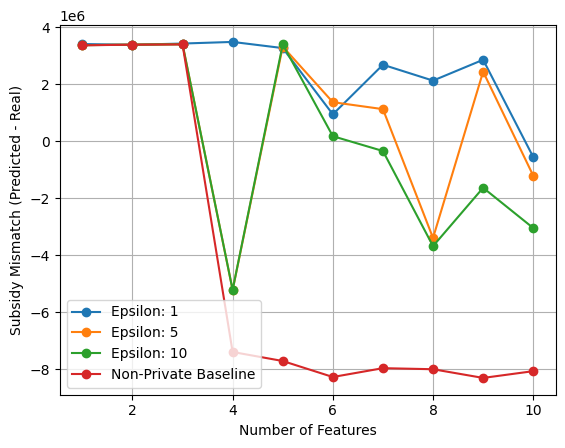

In [104]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_gnb_spend_diffs[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_gnb_spend_diffs[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of Baseline vs Private Gaussian Naive Bayes for Different Number of Features")
plt.grid(axis="both")
plt.legend();

### GNB Comparison Using Top 6 Features

In [105]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

min_bounds_X = [-3 for _ in range(X_train_top6.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top6.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" GNB model using DP version with infinite epsilon
base_gnb = dp_gnb(epsilon=float('inf'), bounds=bounds_X, random_state=42).fit(X_train_top6, y_train)
base_gnb_preds = cross_val_predict(base_gnb, X_test_top6, y_test, cv=10)

# Get Accuracy
base_gnb_accuracy = accuracy_score(y_test, base_gnb_preds)

# Get Subsidy Mismatch
base_gnb_spend_diff = getTotalSpendDiff(X_test, base_gnb_preds, real_spend)

In [110]:
epsilons = np.logspace(-2, 0.5, 50)
priv_gnb_accuracies = []
priv_gnb_spend_diffs = []

for e in range(len(epsilons)):
    priv_gnb = dp_gnb(epsilon=epsilons[e], bounds=bounds_X, random_state=42).fit(X_train_top6, y_train)
    priv_gnb_preds = cross_val_predict(priv_gnb, X_test_top6, y_test, cv=10)

    # Get Accuracy
    priv_gnb_accuracies.append(accuracy_score(y_test, priv_gnb_preds))

    # Get Subsidy Mismatch
    priv_gnb_spend_diffs.append(getTotalSpendDiff(X_test, priv_gnb_preds, real_spend))
    
print("Accuracies:", priv_gnb_accuracies)
print("Subsidy Spend Differences:", priv_gnb_spend_diffs)

Accuracies: [0.7739624046156709, 0.7592592592592593, 0.7574911595012097, 0.7574911595012097, 0.7574911595012097, 0.7573050437372045, 0.7574911595012097, 0.7574911595012097, 0.7575842173832124, 0.7624232272473479, 0.7593523171412618, 0.7600967801972827, 0.5802158942862461, 0.7813139772938767, 0.7720081890936162, 0.7643774427694026, 0.7644705006514052, 0.765680253117439, 0.7667038898194677, 0.7668900055834729, 0.7669830634654755, 0.7694956262795459, 0.7156151126000372, 0.7979713381723432, 0.8099758049506793, 0.7873627396240461, 0.791178112786153, 0.7949004280662572, 0.7996463800483901, 0.8082077051926299, 0.8129536571747628, 0.8103480364786897, 0.8165829145728644, 0.820212171970966, 0.8233761399590546, 0.8241206030150754, 0.7775916620137726, 0.8257025870091197, 0.8243997766610832, 0.8252372975991067, 0.8255164712451145, 0.8266331658291457, 0.8280290340591848, 0.8279359761771822, 0.828680439233203, 0.8296110180532291, 0.828680439233203, 0.7886655499720826, 0.7780569514237856, 0.7839195979

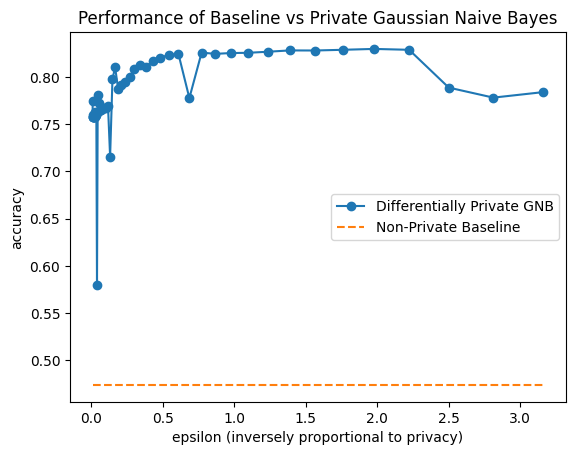

In [111]:
plt.plot(epsilons, priv_gnb_accuracies, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Gaussian Naive Bayes")
plt.grid(axis="both")
plt.legend();

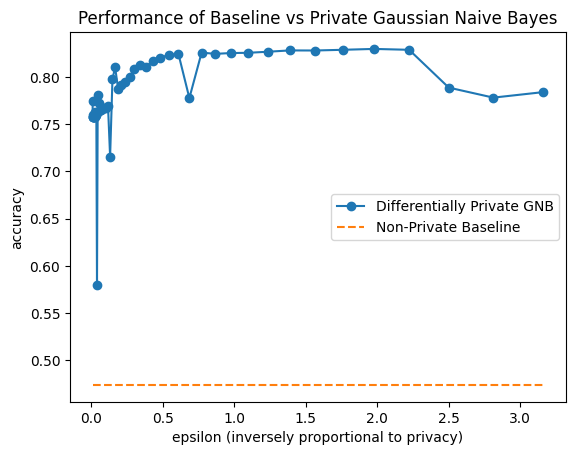

In [112]:
plt.plot(epsilons[:175], priv_gnb_accuracies[:175], '-o', label="Differentially Private GNB")
plt.plot(epsilons[:175], base_gnb_accuracy * np.ones_like(epsilons[:175]), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Gaussian Naive Bayes")
plt.grid(axis="both")
plt.legend();

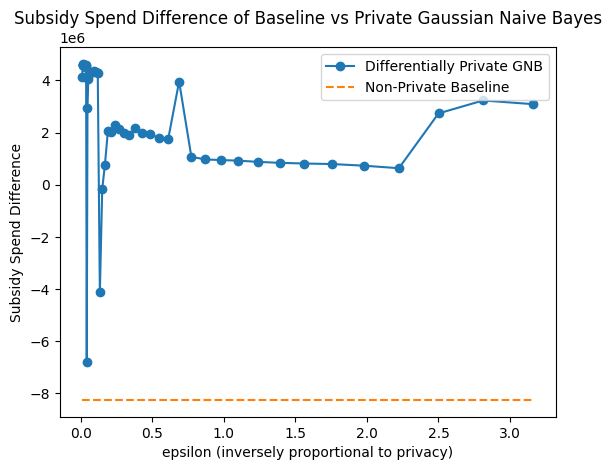

In [113]:
plt.plot(epsilons, priv_gnb_spend_diffs, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Gaussian Naive Bayes")
plt.grid(axis="both")
plt.legend();

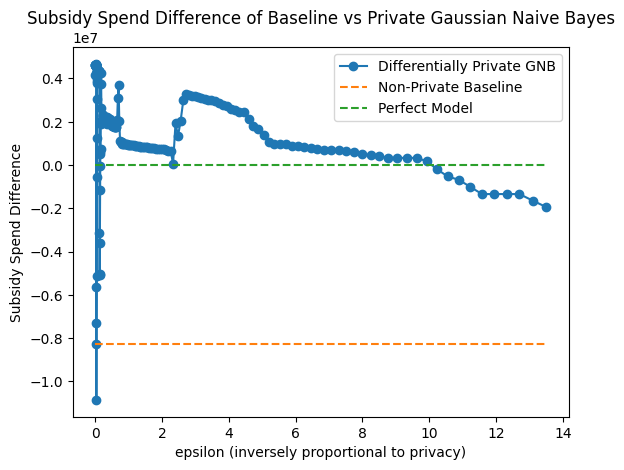

In [118]:
plt.plot(epsilons[:235], priv_gnb_spend_diffs[:235], '-o', label="Differentially Private GNB")
plt.plot(epsilons[:235], base_gnb_spend_diff * np.ones_like(epsilons[:235]), '--', label="Non-Private Baseline")
plt.plot(epsilons[:235], np.zeros(235), '--', label="Perfect Model")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Gaussian Naive Bayes")
plt.grid(axis="both")
plt.legend();

### Top 6 Features, Averaging Performance

In [114]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

min_bounds_X = [-3 for _ in range(X_train_top6.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top6.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" GNB model using DP version with infinite epsilon
base_gnb = dp_gnb(epsilon=float('inf'), bounds=bounds_X, random_state=42).fit(X_train_top6, y_train)
base_gnb_preds = cross_val_predict(base_gnb, X_test_top6, y_test, cv=10)

# Get Accuracy
base_gnb_accuracy = accuracy_score(y_test, base_gnb_preds)

# Get Subsidy Mismatch
base_gnb_spend_diff = getTotalSpendDiff(X_test, base_gnb_preds, real_spend)

In [115]:
epsilons = np.logspace(-2, 0.75, 50)
priv_gnb_accuracies = []
priv_gnb_spend_diffs = []

for e in range(len(epsilons)):
    current_accuracies = []
    current_spend_diffs = []

    for i in range(10):
        priv_gnb = dp_gnb(epsilon=epsilons[e], bounds=bounds_X, random_state=42).fit(X_train_top6, y_train)
        priv_gnb_preds = cross_val_predict(priv_gnb, X_test_top6, y_test, cv=10)

        # Get Accuracy
        current_accuracies.append(accuracy_score(y_test, priv_gnb_preds))

        # Get Subsidy Mismatch
        current_spend_diffs.append(getTotalSpendDiff(X_test, priv_gnb_preds, real_spend))
    
    priv_gnb_accuracies.append(np.mean(current_accuracies))
    priv_gnb_spend_diffs.append(np.mean(current_spend_diffs))
    
print("Accuracies:", priv_gnb_accuracies)
print("Subsidy Spend Differences:", priv_gnb_spend_diffs)

Accuracies: [0.7739624046156709, 0.7592592592592593, 0.7574911595012097, 0.7574911595012097, 0.7574911595012097, 0.7573050437372045, 0.7574911595012097, 0.7575842173832124, 0.7583286804392333, 0.7593523171412617, 0.7600967801972827, 0.6845337800111669, 0.7822445561139029, 0.7677275265214963, 0.7643774427694027, 0.7648427321794156, 0.7667038898194677, 0.766890005583473, 0.7669830634654755, 0.7690303368695328, 0.7156151126000372, 0.8002047273404058, 0.7823376139959055, 0.7878280290340591, 0.7939698492462312, 0.7955518332402755, 0.8030895216824865, 0.8101619207146845, 0.8102549785966872, 0.8161176251628512, 0.8202121719709659, 0.823469197841057, 0.8240275451330727, 0.8054159687325516, 0.825144239717104, 0.8250511818351015, 0.8254234133631119, 0.8257956448911223, 0.8280290340591849, 0.8279359761771822, 0.828680439233203, 0.8296110180532292, 0.8121161362367392, 0.7816862088218872, 0.7797319932998324, 0.7856876977479993, 0.7935976177182207, 0.8028103480364785, 0.811930020472734, 0.8257956448

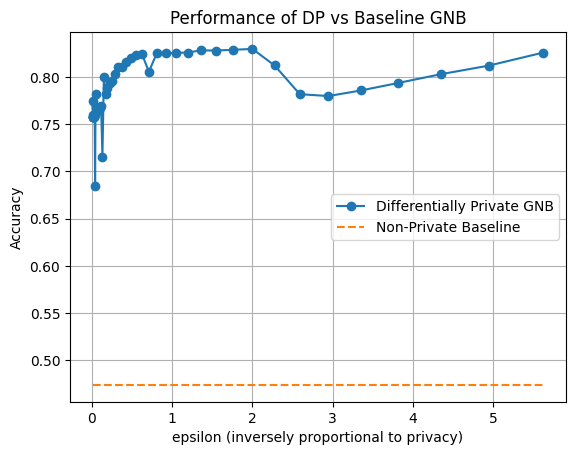

In [122]:
plt.plot(epsilons, priv_gnb_accuracies, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline GNB")
plt.grid(axis="both")
plt.legend();

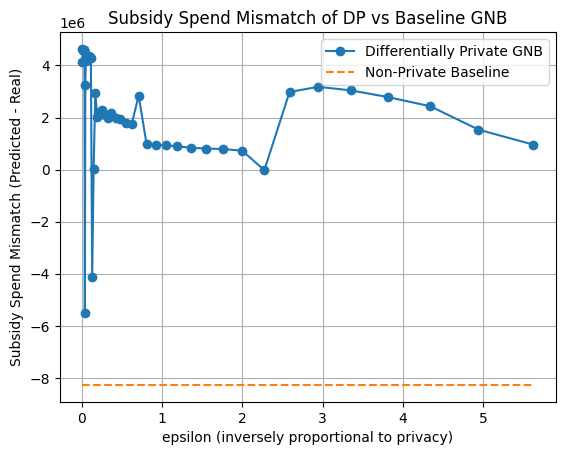

In [123]:
plt.plot(epsilons, priv_gnb_spend_diffs, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Mismatch (Predicted - Real)")
plt.title("Subsidy Spend Mismatch of DP vs Baseline GNB")
plt.grid(axis="both")
plt.legend();

### GNB Comparison Using All Features

In [124]:
min_bounds_X = [-3 for _ in range(X_train.shape[1])]
max_bounds_X = [3 for _ in range(X_train.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Gaussian Naive Bayes model using DP version with infinite epsilon
base_gnb = dp_gnb(epsilon=float('inf'), bounds=bounds_X, random_state=42).fit(X_train_scaled, y_train)
base_gnb_preds = cross_val_predict(base_gnb, X_test_scaled, y_test, cv=10)

# Get Accuracy
base_gnb_accuracy = accuracy_score(y_test, base_gnb_preds)

# Get Subsidy Mismatch
base_gnb_spend_diff = getTotalSpendDiff(X_test, base_gnb_preds, real_spend)

In [125]:
epsilons = np.logspace(-2, 0.75, 50)
priv_gnb_accuracies = []
priv_gnb_spend_diffs = []

for e in range(len(epsilons)):
    priv_gnb = dp_gnb(epsilon=epsilons[e], bounds=bounds_X, random_state=42).fit(X_train_scaled, y_train)
    priv_gnb_preds = cross_val_predict(priv_gnb, X_test_scaled, y_test, cv=10)

    # Get Accuracy
    priv_gnb_accuracies.append(accuracy_score(y_test, priv_gnb_preds))
    
    # Get Subsidy Mismatch
    priv_gnb_spend_diffs.append(getTotalSpendDiff(X_test, priv_gnb_preds, real_spend))
    
print("Accuracies:", priv_gnb_accuracies)
print("Subsidy Spend Differences:", priv_gnb_spend_diffs)

Accuracies: [0.2485576028289596, 0.5851479620323842, 0.32272473478503627, 0.36273962404615673, 0.2637260375953843, 0.7407407407407407, 0.6629443513865625, 0.707891308393821, 0.5310813325888702, 0.4312302252000744, 0.628140703517588, 0.7494881816489857, 0.4756188349153173, 0.6904894844593337, 0.731248836776475, 0.7497673552949935, 0.7436255350828215, 0.6282337613995905, 0.7268751163223525, 0.7442769402568398, 0.7479061976549414, 0.6658291457286433, 0.5739810161920714, 0.7359947887586078, 0.525963149078727, 0.7060301507537688, 0.6962590731434952, 0.6975618834915317, 0.6079471431230226, 0.6499162479061976, 0.7060301507537688, 0.6227433463614368, 0.6877908058812582, 0.6901172529313233, 0.5805881258142565, 0.6782989019169924, 0.6703889819467709, 0.5727712637260376, 0.5817978782802904, 0.6926298157453936, 0.6872324585892425, 0.6791364228550159, 0.6747627024008933, 0.6091568955890564, 0.5576028289596129, 0.6438674855760282, 0.6998883305415968, 0.6771822073329611, 0.6769960915689559, 0.6559650

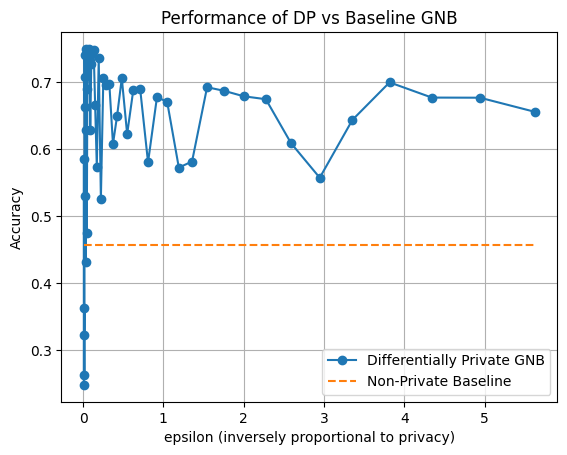

In [128]:
plt.plot(epsilons, priv_gnb_accuracies, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline GNB")
plt.grid(axis="both")
plt.legend();

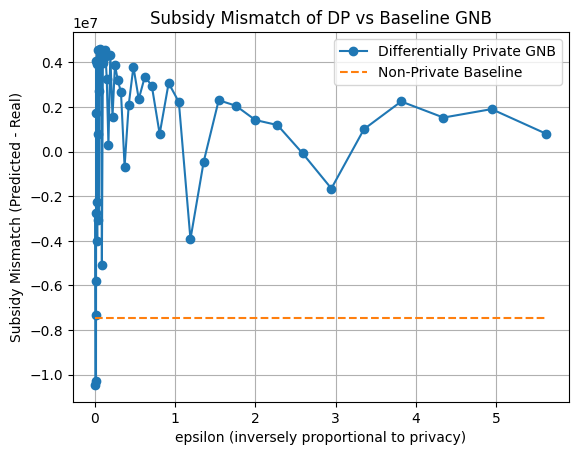

In [129]:
plt.plot(epsilons, priv_gnb_spend_diffs, '-o', label="Differentially Private GNB")
plt.plot(epsilons, base_gnb_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.plot(epsilons, np.zeros(len(epsilons)), '--', label="Perfect Model")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline GNB")
plt.grid(axis="both")
plt.legend();

## Decision Tree

### Baseline Model

In [125]:
#Create Baseline Decision Tree Model
dt = sklearn_dt().fit(X_train_scaled, y_train)  
dt_pred = cross_val_predict(dt, X_test_scaled, y_test, cv=10)

# Get Accuracy
dt_acc = accuracy_score(y_test, dt_pred)

# Get Subsidy Mismatch
real_spend = getRealSpend(X_test, y_test)
dt_spend_diff = getTotalSpendDiff(X_test, dt_pred, real_spend)
    
print("Baseline Accuracy:", dt_acc)
print("Baseline Subsidy Spend Difference:", dt_spend_diff)

Baseline Accuracy: 0.8095105155406663
Baseline Subsidy Spend Difference: -125000


### Trying for Different Numbers of Features

In [ ]:
ks = range(1, len(X_train.columns) + 1)
epsilons = [0.01, 0.1, 1]

base_dt_accuracies = []
base_dt_spend_diffs = []

priv_dt_accuracies = [[] for _ in epsilons]
priv_dt_spend_diffs = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    classes = ['<=50K', '>50K']

    # Create "baseline" Decision Tree model using DP version with infinite epsilon
    base_dt = dp_dt(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_topk, y_train)
    base_dt_preds = cross_val_predict(base_dt, X_test_topk, y_test, cv=10)

    # Get Accuracy
    base_dt_accuracies.append(accuracy_score(y_test, base_dt_preds))

    # Get Subsidy Mismatch
    base_dt_spend_diffs.append(getTotalSpendDiff(X_test, base_dt_preds, real_spend))

    for e in range(len(epsilons)):
        priv_dt = dp_dt(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_topk, y_train)
        priv_dt_preds = cross_val_predict(priv_dt, X_test_topk, y_test, cv=10)

        # Get Accuracy
        priv_dt_accuracies[e].append(accuracy_score(y_test, priv_dt_preds))

        # Get Subsidy Mismatch
        priv_dt_spend_diffs[e].append(getTotalSpendDiff(X_test, priv_dt_preds, real_spend))

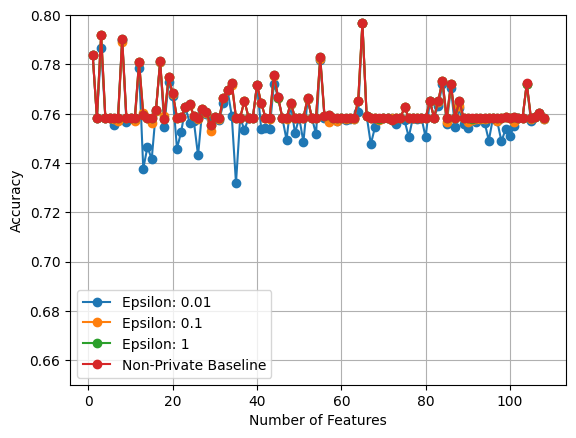

In [175]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_dt_accuracies[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_dt_accuracies * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.ylim(0.65, 0.80)
plt.title("Performance of Baseline vs Private Decision Tree for Different Number of Features")
plt.grid(axis="both")
plt.legend();

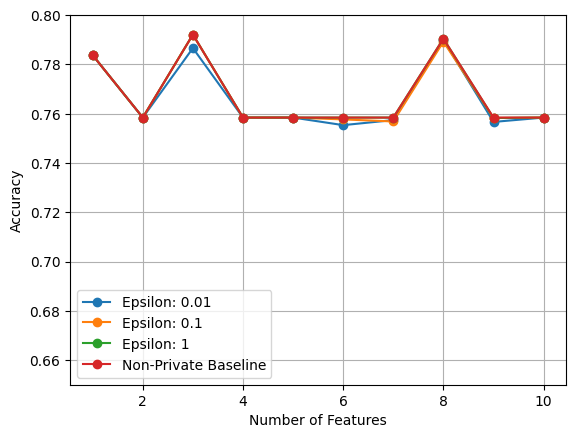

In [177]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_dt_accuracies[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_dt_accuracies[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.ylim(0.65, 0.80)
plt.title("Performance of Baseline vs Private Decision Tree for Different Number of Features")
plt.grid(axis="both")
plt.legend();

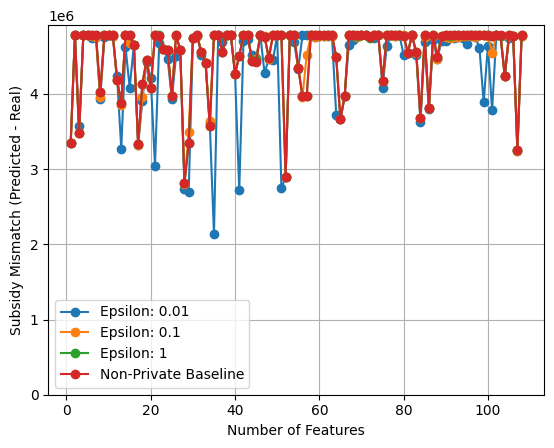

In [178]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_dt_spend_diffs[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_dt_spend_diffs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.ylim(0)
plt.title("Subsidy Mismatch of Baseline vs Private Decision Tree for Different Number of Features")
plt.grid(axis="both")
plt.legend();

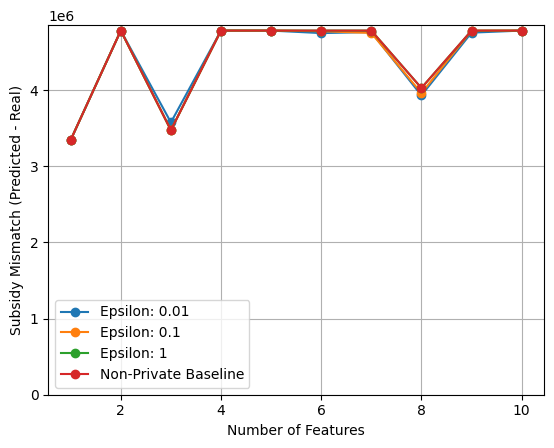

In [179]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_dt_spend_diffs[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_dt_spend_diffs[:10] * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.ylim(0)
plt.title("Subsidy Mismatch of Baseline vs Private Decision Tree for Different Number of Features")
plt.grid(axis="both")
plt.legend();

### Decision Tree Comparison Using Top 6 Features

In [137]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

min_bounds_X = [-3 for _ in range(X_train_top6.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top6.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

classes = ['<=50K', '>50K']

# Create "baseline" Decision Tree model using DP version with infinite epsilon
base_dt = dp_dt(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)
base_dt_preds = cross_val_predict(base_dt, X_test_top6, y_test, cv=10)

# Get Accuracy
base_dt_accuracy = accuracy_score(y_test, base_dt_preds)

# Get Subsidy Mismatch
base_dt_spend_diff = getTotalSpendDiff(X_test, base_dt_preds, real_spend)

In [138]:
epsilons = np.logspace(-2, 0, 25)
priv_dt_accuracies = []
priv_dt_spend_diffs = []

for e in range(len(epsilons)):
    priv_dt = dp_dt(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)
    priv_dt_preds = cross_val_predict(priv_dt, X_test_top6, y_test, cv=10)

    # Get Accuracy
    priv_dt_accuracies.append(accuracy_score(y_test, priv_dt_preds))

    # Get Subsidy Mismatch
    priv_dt_spend_diffs.append(getTotalSpendDiff(X_test, priv_dt_preds, real_spend))
    
print("Accuracies:", priv_dt_accuracies)
print("Subsidy Spend Differences:", priv_dt_spend_diffs)

Accuracies: [0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.7578633910292202, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358, 0.7584217383212358]
Subsidy Spend Differences: [4749000, 4749000, 4749000, 4749000, 4749000, 4749000, 4749000, 4749000, 4774000, 4774000, 4774000, 4774000, 4774000, 4776000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000, 4782000]


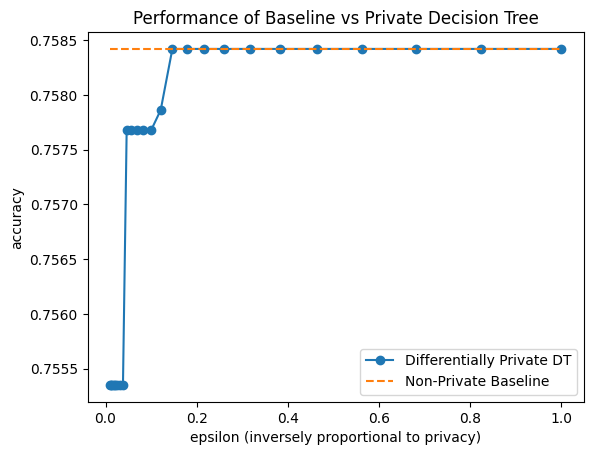

In [139]:
plt.plot(epsilons, priv_dt_accuracies, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Decision Tree")
plt.grid(axis="both")
plt.legend();

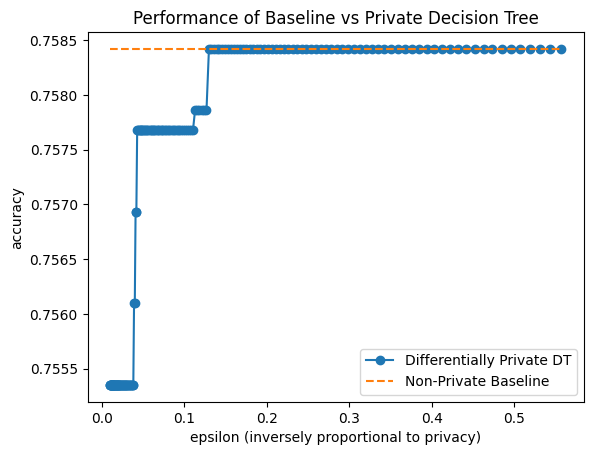

In [202]:
plt.plot(epsilons[:175], priv_dt_accuracies[:175], '-o', label="Differentially Private DT")
plt.plot(epsilons[:175], base_dt_accuracy * np.ones_like(epsilons[:175]), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Decision Tree")
plt.grid(axis="both")
plt.legend();

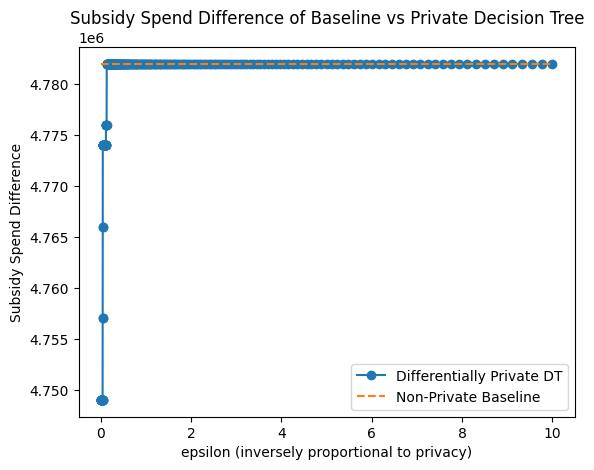

In [203]:
plt.plot(epsilons, priv_dt_spend_diffs, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Decision Tree")
plt.grid(axis="both")
plt.legend();

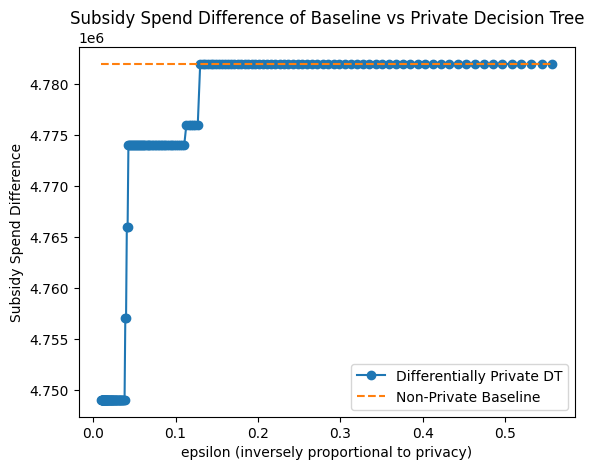

In [204]:
plt.plot(epsilons[:175], priv_dt_spend_diffs[:175], '-o', label="Differentially Private DT")
plt.plot(epsilons[:175], base_dt_spend_diff * np.ones_like(epsilons[:175]), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Decision Tree")
plt.grid(axis="both")
plt.legend();

### Top 6 Features, Averaging Performance

In [140]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

min_bounds_X = [-3 for _ in range(X_train_top6.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top6.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

classes = ['<=50K', '>50K']

# Create "baseline" Decision Tree model using DP version with infinite epsilon
base_dt = dp_dt(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)
base_dt_preds = cross_val_predict(base_dt, X_test_top6, y_test, cv=10)

# Get Accuracy
base_dt_accuracy = accuracy_score(y_test, base_dt_preds)

# Get Subsidy Mismatch
base_dt_spend_diff = getTotalSpendDiff(X_test, base_dt_preds, real_spend)

In [141]:
epsilons = np.logspace(-2, 0, 25)
priv_dt_accuracies = []
priv_dt_spend_diffs = []

for e in range(len(epsilons)):
    current_accuracies = []
    current_spend_diffs = []

    for i in range(10):
        priv_dt = dp_dt(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)
        priv_dt_preds = cross_val_predict(priv_dt, X_test_top6, y_test, cv=10)

        # Get Accuracy
        current_accuracies.append(accuracy_score(y_test, priv_dt_preds))

        # Get Subsidy Mismatch
        current_spend_diffs.append(getTotalSpendDiff(X_test, priv_dt_preds, real_spend))
    
    priv_dt_accuracies.append(np.mean(current_accuracies))
    priv_dt_spend_diffs.append(np.mean(current_spend_diffs))
    
print("Accuracies:", priv_dt_accuracies)
print("Subsidy Spend Differences:", priv_dt_spend_diffs)

Accuracies: [0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.7553508282151499, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.757677275265215, 0.7578633910292202, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357, 0.7584217383212357]
Subsidy Spend Differences: [4749000.0, 4749000.0, 4749000.0, 4749000.0, 4749000.0, 4749000.0, 4749000.0, 4749000.0, 4774000.0, 4774000.0, 4774000.0, 4774000.0, 4774000.0, 4776000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0, 4782000.0]


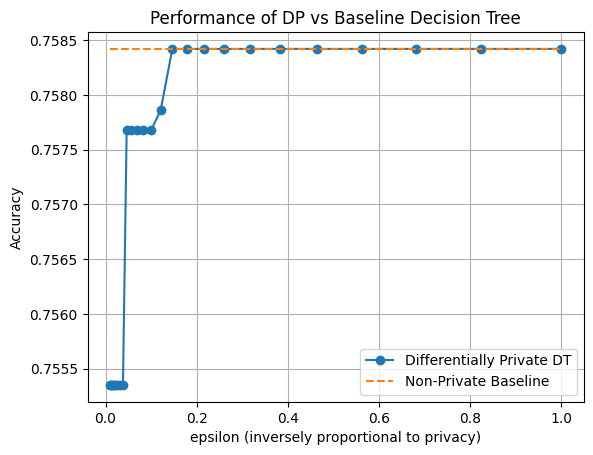

In [142]:
plt.plot(epsilons, priv_dt_accuracies, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Decision Tree")
plt.grid(axis="both")
plt.legend();

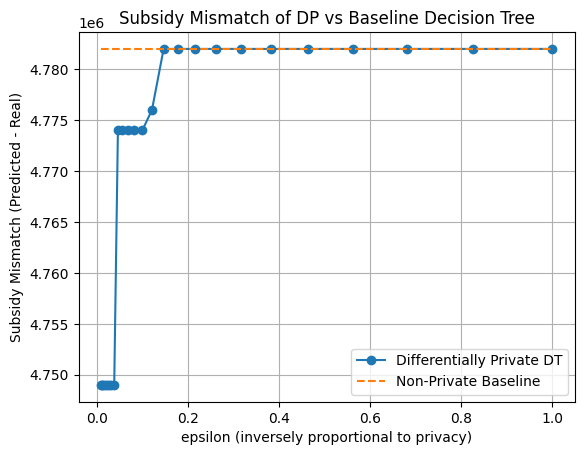

In [145]:
plt.plot(epsilons, priv_dt_spend_diffs, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline Decision Tree")
plt.grid(axis="both")
plt.legend();

### Decision Tree Comparison Using All Features

In [180]:
min_bounds_X = [-3 for _ in range(X_train.shape[1])]
max_bounds_X = [3 for _ in range(X_train.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

classes = ['<=50K', '>50K']

# Create "baseline" Decision Tree model using DP version with infinite epsilon
base_dt = dp_dt(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_scaled, y_train)

base_dt_preds = cross_val_predict(base_dt, X_test_scaled, y_test, cv=10)

# Get Accuracy
base_dt_accuracy = accuracy_score(y_test, base_dt_preds)

# Get Subsidy Mismatch
base_dt_spend_diff = getTotalSpendDiff(X_test, base_dt_preds, real_spend)

In [181]:
epsilons = np.logspace(-2, 0.3, 25)
priv_dt_accuracies = []
priv_dt_spend_diffs = []

for e in range(len(epsilons)):
    priv_dt = dp_dt(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_scaled, y_train)
    priv_dt_preds = cross_val_predict(priv_dt, X_test_scaled, y_test, cv=10)

    # Get Accuracy
    priv_dt_accuracies.append(accuracy_score(y_test, priv_dt_preds))
    
    # Get Subsidy Mismatch
    priv_dt_spend_diffs.append(getTotalSpendDiff(X_test, priv_dt_preds, real_spend))
    
print("Accuracies:", priv_dt_accuracies)
print("Subsidy Spend Differences:", priv_dt_spend_diffs)

Accuracies: [0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7579564489112228, 0.7580495067932254, 0.758142564675228, 0.758142564675228, 0.7583286804392332, 0.7582356225572306, 0.7582356225572306, 0.7583286804392332, 0.7583286804392332, 0.7583286804392332, 0.7583286804392332]
Subsidy Spend Differences: [4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4774000, 4775000, 4776000, 4777000, 4777000, 4780000, 4779000, 4779000, 4781000, 4781000, 4781000, 4781000]


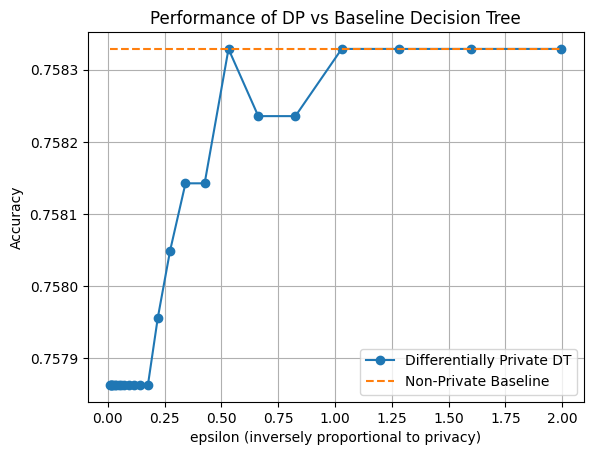

In [182]:
plt.plot(epsilons, priv_dt_accuracies, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Accuracy")
plt.title("Performance of DP vs Baseline Decision Tree")
plt.grid(axis="both")
plt.legend();

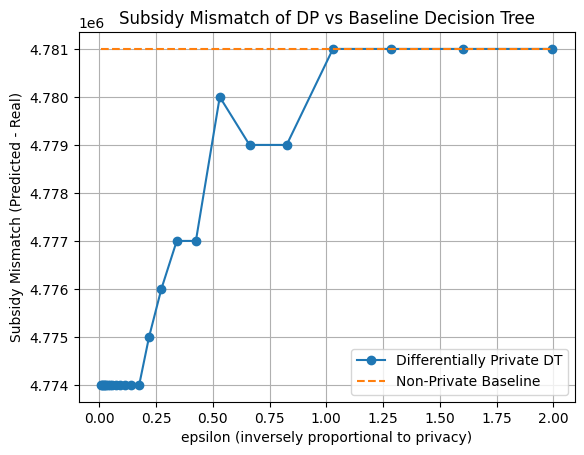

In [183]:
plt.plot(epsilons, priv_dt_spend_diffs, '-o', label="Differentially Private DT")
plt.plot(epsilons, base_dt_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.plot(epsilons, np.zeros(len(epsilons)), '--', label="Perfect Model")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of DP vs Baseline Decision Tree")
plt.grid(axis="both")
plt.legend();

## Random Forest

### Baseline Model

In [209]:
#Create Baseline Random Forest Model
rf = sklearn_rf().fit(X_train_scaled, y_train)  
rf_pred = cross_val_predict(rf, X_test_scaled, y_test, cv=10)

# Get Accuracy
rf_acc = accuracy_score(y_test, rf_pred)

# Get Subsidy Mismatch
real_spend = getRealSpend(X_test, y_test)
rf_spend_diff = getTotalSpendDiff(X_test, rf_pred, real_spend)
    
print("Baseline Accuracy:", rf_acc)
print("Baseline Subsidy Spend Difference:", rf_spend_diff)

Baseline Accuracy: 0.8510143309138284
Baseline Subsidy Spend Difference: 533000


### Trying for Different Numbers of Features

In [ ]:
ks = range(1, len(X_train.columns) + 1)
epsilons = [0.001, 0.01, 0.1, 1, 5]

base_rf_accuracies = []
base_rf_spend_diffs = []

priv_rf_accuracies = [[] for _ in epsilons]
priv_rf_spend_diffs = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    classes = ['<=50K', '>50K']

    # Create "baseline" Random Forest model using DP version with infinite epsilon
    base_rf = dp_rf(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_topk, y_train)
    base_rf_preds = cross_val_predict(base_rf, X_test_topk, y_test, cv=10)

    # Get Accuracy
    base_rf_accuracies.append(accuracy_score(y_test, base_rf_preds))

    # Get Subsidy Mismatch
    base_rf_spend_diffs.append(getTotalSpendDiff(X_test, base_rf_preds, real_spend))

    for e in range(len(epsilons)):
        priv_rf = dp_rf(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_topk, y_train)
        priv_rf_preds = cross_val_predict(priv_rf, X_test_topk, y_test, cv=10)

        # Get Accuracy
        priv_rf_accuracies[e].append(accuracy_score(y_test, priv_rf_preds))

        # Get Subsidy Mismatch
        priv_rf_spend_diffs[e].append(getTotalSpendDiff(X_test, priv_rf_preds, real_spend))

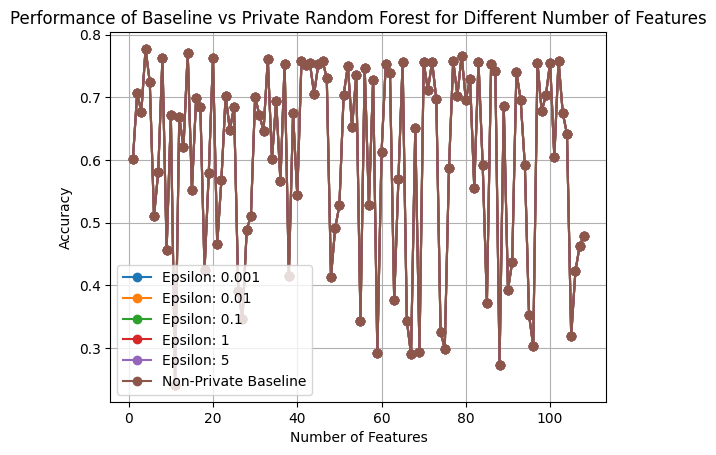

In [211]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_rf_accuracies[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_rf_accuracies * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Performance of Baseline vs Private Random Forest for Different Number of Features")
plt.grid(axis="both")
plt.legend();

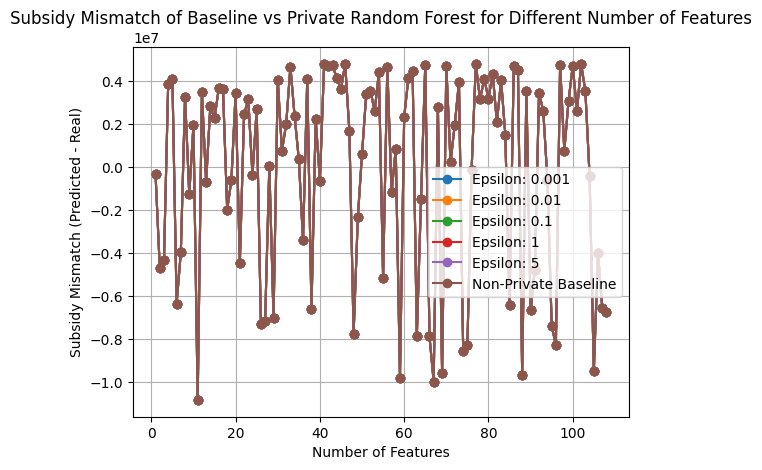

In [212]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_rf_spend_diffs[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_rf_spend_diffs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("Subsidy Mismatch (Predicted - Real)")
plt.title("Subsidy Mismatch of Baseline vs Private Random Forest for Different Number of Features")
plt.grid(axis="both")
plt.legend();

### Random Forest Comparison Using Top 6 Features

In [213]:
X_train_top6, X_test_top6 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 6)

min_bounds_X = [-3 for _ in range(X_train_top6.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top6.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

classes = ['<=50K', '>50K']

# Create "baseline" Random Forest model using DP version with infinite epsilon
base_rf = dp_rf(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)

base_rf_preds = cross_val_predict(base_rf, X_test_top6, y_test, cv=10)

# Get Accuracy
base_rf_accuracy = accuracy_score(y_test, base_rf_preds)

# Get Subsidy Mismatch
base_rf_spend_diff = getTotalSpendDiff(X_test, base_rf_preds, real_spend)

In [214]:
epsilons = np.logspace(-2, 1, 300)
priv_rf_accuracies = []
priv_rf_spend_diffs = []

for e in range(len(epsilons)):
    priv_rf = dp_rf(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_top6, y_train)
    priv_rf_preds = cross_val_predict(priv_rf, X_test_top6, y_test, cv=10)

    # Get Accuracy
    priv_rf_accuracies.append(accuracy_score(y_test, priv_rf_preds))

    # Get Subsidy Mismatch
    priv_rf_spend_diffs.append(getTotalSpendDiff(X_test, priv_rf_preds, real_spend))
    
print("Accuracies:", priv_rf_accuracies)
print("Subsidy Spend Differences:", priv_rf_spend_diffs)

Accuracies: [0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284, 0.510143309138284,

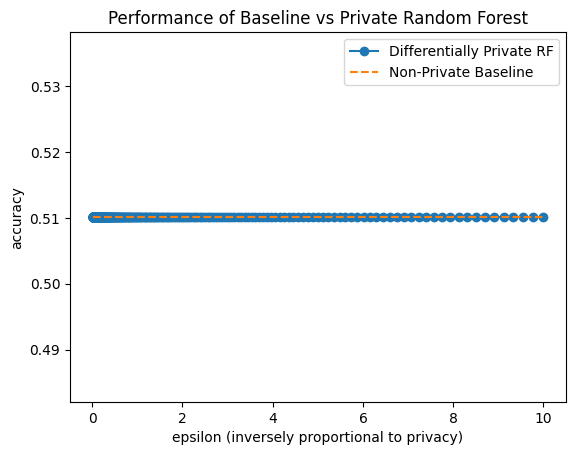

In [215]:
plt.plot(epsilons, priv_rf_accuracies, '-o', label="Differentially Private RF")
plt.plot(epsilons, base_rf_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Random Forest")
plt.grid(axis="both")
plt.legend();

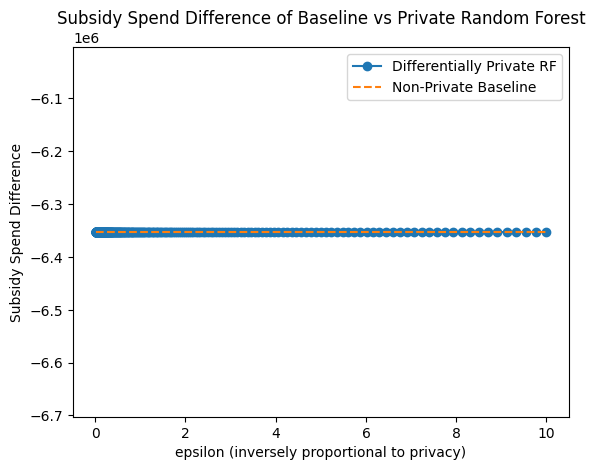

In [216]:
plt.plot(epsilons, priv_rf_spend_diffs, '-o', label="Differentially Private RF")
plt.plot(epsilons, base_rf_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Random Forest")
plt.grid(axis="both")
plt.legend();

### Random Forest Comparison Using All Features

In [217]:
min_bounds_X = [-3 for _ in range(X_train.shape[1])]
max_bounds_X = [3 for _ in range(X_train.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

classes = ['<=50K', '>50K']

# Create "baseline" Random Forest model using DP version with infinite epsilon
base_rf = dp_rf(epsilon=float('inf'), bounds=bounds_X, classes=classes, random_state=42).fit(X_train_scaled, y_train)
base_rf_preds = cross_val_predict(base_rf, X_test_scaled, y_test, cv=10)

# Get Accuracy
base_rf_accuracy = accuracy_score(y_test, base_rf_preds)

# Get Subsidy Mismatch
base_rf_spend_diff = getTotalSpendDiff(X_test, base_rf_preds, real_spend)

In [218]:
epsilons = np.logspace(-2, 1, 300)
priv_rf_accuracies = []
priv_rf_spend_diffs = []

for e in range(len(epsilons)):
    priv_rf = dp_dt(epsilon=epsilons[e], bounds=bounds_X, classes=classes, random_state=42).fit(X_train_scaled, y_train)
    priv_rf_preds = cross_val_predict(priv_rf, X_test_scaled, y_test, cv=10)

    # Get Accuracy
    priv_rf_accuracies.append(accuracy_score(y_test, priv_rf_preds))
    
    # Get Subsidy Mismatch
    priv_rf_spend_diffs.append(getTotalSpendDiff(X_test, priv_rf_preds, real_spend))
    
print("Accuracies:", priv_rf_accuracies)
print("Subsidy Spend Differences:", priv_rf_spend_diffs)

Accuracies: [0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.7578633910292202, 0.75786

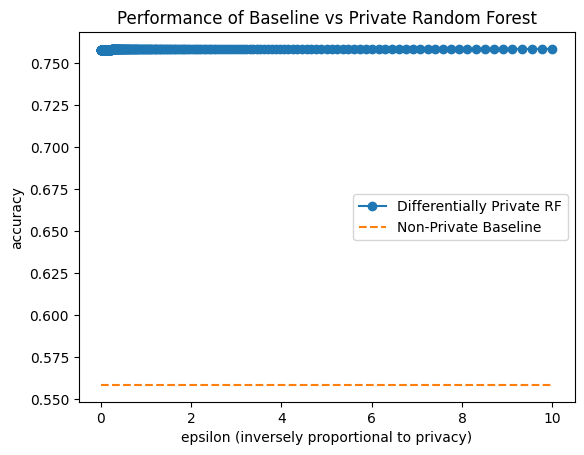

In [219]:
plt.plot(epsilons, priv_rf_accuracies, '-o', label="Differentially Private RF")
plt.plot(epsilons, base_rf_accuracy * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("accuracy")
plt.title("Performance of Baseline vs Private Random Forest")
plt.grid(axis="both")
plt.legend();

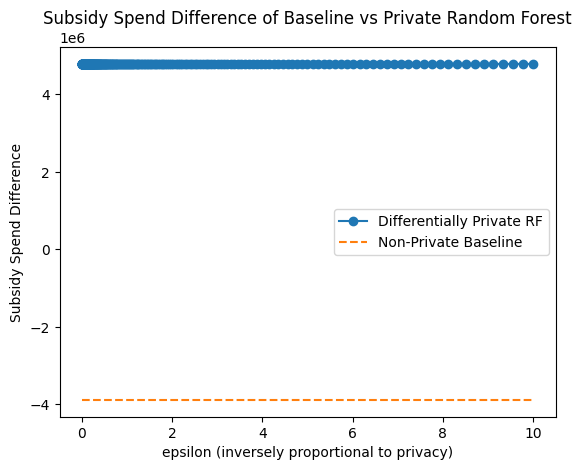

In [220]:
plt.plot(epsilons, priv_rf_spend_diffs, '-o', label="Differentially Private RF")
plt.plot(epsilons, base_rf_spend_diff * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.plot(epsilons, np.zeros(len(epsilons)), '--', label="Perfect Model")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Subsidy Spend Difference")
plt.title("Subsidy Spend Difference of Baseline vs Private Random Forest")
plt.grid(axis="both")
plt.legend();